# P3
## Desenvolvido e discutido por Felipe Arruda-196862 e Leonardo Koike-201332
## A implementação e discussão foi feita em colaboração por ambos os integrantes do grupo

# Evolucionary Model
## Introdução
* The evolutionary model adopted -> Genetic Algorithms
* Variations on parameters -> Population size/Crossover rate/Mutation rate/Generation interval/Stopping criteria
* Fitness function adopted -> combination between max score and has won
* Population size -> population_size
* Stop criteria -> max_generation or population_average hasn`t changed more than 0.005
* Selection technique -> Roulette Method
* Crossover technique -> Single Point Crossover
* Replacement method -> Steady State, bring 10% of the original population among with the children
* Mutation rate -> 0.1
* Crossover rate -> 0.8

Como podemos ver acima, decidimos tomar uma abordagem de algorítmo genético para resolução do problema do Pacman. Algumas informações adicionais sobre o modelo proposto: <br>
* Um individuo é composto de uma série de genes que podem ter o valor 'L' ou 'R', idicando ao pacman se ele deve virar à esquerda ou à direita respectivamente. O número de genes é determinado por um parâmetro passado na criação da população. Um exemplo seria: 'LRRLLLRLRRRL' de um individuo com 12 genes.
* Inicialmente, para a fitness do individuo, pensamos em combinar a pontuação média com um bonus caso o pacman vencesse os mapas, esse bonus seria proporcional à complexidade de cada mapa e arbitrário na linha de código. Entretanto, após testes decidimos seguir com apenas com a pontuação média do individuo como sua fitness.
* As gerações vão mudando até atingir a geração máxima ou a diferença percentual entre uma média de população e sua anterior menor que 0,5% positiva, mantendo ou aumentando o winrate em relação a geração anterior.
* A seleção dos indivíduos tanto para crossover quanto para mutação é por roleta, garantindo que não tenham valores negativos na fitness aplicando uma máscara com o valor mínimo do vetor. Além disso, utilizamos transformação exponencial na fitness para a seleção.
* A função de crossover basicamente realiza crossover de 1 ponto entre os dois vetores de caracteres, de modo que sejam criados 2 individuos com as características dos pais. Já a mutação altera apenas 1 posição do vetor.
* O stedy state traz um percentual dos melhores individuos de uma geração para a outra, sem que eles sejam repetidos, ou seja, o mesmo individuo não é colcado mais de uma vez na geração filha pelo stedy state, para não gerar dominância deste indivíduo.
* Para que o codigo e nosso individuo rode, temos um agente chamado "EvolutionAgent" em "pacmanAgents.py", que basicamente escolhe virar de acordo com a listagem de operações passadas pelos genes do individuo. Caso não seja possível virar, ele continua em frente. Se ele não puder seguir em frente nem virar, ele dá meia volta. Se ele chegar ao final da listagem de passos a serem seguidos, ele retorna ao passo inicial.
* Após uma série de testes, percebemos que nosso indivíduos não estava apto por conta da movimentação randômica dos fantasmas, o que gerava muito problema na evolução do agente. Assim, decidimos por utilizar a flag "-f" na execução do jogo, que fixava o caminho realizado pelo fantasma. Isso resultou na resolução do seguinte problema: qual o melhor caminho que o pacman pode realizar no mapa sem ser interceptado por um fantasma? Ou seja, o pacman deve percorrer os corredores do labirinto, sem ser interceptado pelo fantasma e conseguir a maior quantidade de pontos possível. Como os fantasmas percorrem sempre o mesmo caminho no labirinto, não haveria a necessidade de jogar o jogo multiplas vezes, já que o pacman e o fantasma se inteceptariam sempre no mesmo ponto do jogo.

# Implementação e treino

In [4]:
## Imports
import random
import numpy as np
from statistics import mean
random.seed(10)
maps = ['smallClassic', 'mediumClassic', 'originalClassic']

In [2]:
## Inicialização da população com tamanho passado pelo parâmetro
# retorna a população criada
def population_inicialization(population_size, min_carac, max_carac):
    population = []
    for i in range(population_size):
        len  = random.randint(min_carac, max_carac)
        individuo = ""
        for c in range(len):
            carac = random.randint(1, 100)
            if carac >= 50:
                individuo = individuo + 'L'
            else:
                individuo = individuo + 'R'
        population.append(individuo)
    population = np.array(population)
    return population

In [3]:
# Função para realização de crossover de 1 ponto entre 2 individuos
# retorna os filhos destes individuos
def crossover(l, q):
    # converting the string to list for performing the crossover
    l = list(l)
    q = list(q)
  
# generating the random number to perform crossover
    size_l = len(l)
    size_q = len(q)
    size = 0
    size = min(size_l, size_q)
    k = random.randint(0, size-1)
  
# interchanging the genes
    for i in range(0, k):
        l[i], q[i] = q[i], l[i]
    
    l = ''.join(l)
    q = ''.join(q)
    return l, q

In [4]:
# Função que muta 1 gene de um indivíduo
# Retorna individuo mutado
def mutation(i):
    i = list(i)
    
    x = random.randint(0, len(i)-1)
    if i[x] == 'L':
        i[x] = 'R'
    else:
        i[x] = 'L'
    
    i = ''.join(i)
    return i

In [5]:
#selects 1 or 2 individuals in the population taking into account their fitness
def selection(ind_amount, fitness):
    ind = []

    #section to prevent negative values
    min_val = np.min(fitness)
    if min_val < 0:
        fitness = fitness - min_val

    #Exponential Transformation for the fitness
    fitness = np.sqrt(fitness + 1)

    #Selection
    max_val = np.sum(fitness)
    for n in range(ind_amount):
        pick = random.uniform(0, max_val)
        current = 0
        for i in range(len(fitness)):
            current += fitness[i]
            if current > pick:
                ind.append(i)
                break
    return ind

In [6]:
# Função para mudar a geração, recebe a população pai e gera os filhos
# Retorna uma nova população
def change_generation(population, stedy_rate, mutation_rate, crossover_rate, fitness):
    new_pop = []
    fit_temp = fitness.copy()
    pop_temp = population.copy()

    # stedy state part
    i = 0
    size = int(stedy_rate*len(population))
    while i < size:
        if population[np.argmax(fitness)] not in new_pop:
            new_pop.append(population[np.argmax(fitness)])
        else: # esse if impede que eu fique repetindo o mesmo individuo muitas vezes pela seleção dos n melhores da população
            i = i - 1 
        fitness = np.delete(fitness, np.argmax(fitness))
        population = np.delete(population, np.argmax(fitness))
        i = i + 1
        
    population = pop_temp
    fitness = fit_temp

    #crossover part
    for i in range(int(crossover_rate*len(population)/2)):
        idx = selection(2, fitness)
        a, b = crossover(population[idx[0]], population[idx[1]])
        new_pop.append(a)
        new_pop.append(b)
    
    #mutation part
    for i in range(int(mutation_rate*len(population))):
        idx = selection(1, fitness)
        new_pop.append(mutation(population[idx[0]]))
        
    new_pop = np.array(new_pop)
    return new_pop

In [7]:
# Função para gerar o fitness da população
# ela joga o jogo com cada indivíduo em cada um dos mapas e gera as métricas do indivíduo após os jogos
# retorna as métricas dessa população
def playGames(population, maps):
    #initializate generation calculations
    population_avgs = []
    population_wins = []

    for i in population:
        i_scores = []
        i_win = []
        for mapa in maps:
            result = !python pacman.py -p EvolutionAgent -a steps=$i -l $mapa -q -f
            # print(result)
            is_win = int(result[3].split(':')[1].split('/')[0].replace(" ", ""))
            i_win.append(is_win)
            score = float(result[1].split(':')[1].replace(" ", ""))

            # Esse pedaço de código aumentava a fitness para um individuo que ganhava o jogo
            # if is_win == 1 and mapa == 'smallClassic':
            #     score = score + 150
            # elif is_win == 1 and mapa == 'mediumClassic':
            #     score = score + 500
            # elif is_win == 1 and mapa == 'originalClassic':
            #     score = score + 1200

            i_scores.append(score)

        ind_mean = np.mean(i_scores)
        population_avgs = population_avgs + [ind_mean]
        wins = np.sum(i_win)
        population_wins.append(wins)
        
    population_avgs = np.array(population_avgs)
    population_wins = np.array(population_wins)
    return population_avgs, population_wins

In [8]:
# Função para retornar se o treino ainda deve começar se a média não mudar muito pouco
def checkStopCriteria_avg(current_gen, prev_gen):
    diff = current_gen - prev_gen
    ratio = diff/current_gen
    if ratio < 0.005 and ratio > 0:
        return True
    return False

In [9]:
def checkStopCriteria_win(current_gen, prev_gen):
    status = False
    if current_gen >= prev_gen:
        status = True
    return status

In [10]:
# Função para treino da população
def treino(population, maps, max_generation, stedy_rate, mutation_rate, crossover_rate):
    
    #vetor com as populações
    generations =[]
    generations.append(population)

    # valores para avaliação da população
    generation_avg = []
    generation_max_value = []
    generation_max_ind = []
    generation_min_value = []
    generation_win_rate = []

    # variavel que irá controlar o critério de parada do treino
    stop = False

    for g in range(max_generation):
        print("Generation " + str(g))

        # process the fitness for each individual in population
        avgs, wins = playGames(generations[g], maps)

        #calculate the genaration metrics
        generation_max_value.append(max(avgs))
        max_ind_idx = np.where(avgs == generation_max_value[g])
        generation_max_ind.append(generations[g][max_ind_idx[0]])
        generation_min_value.append(np.amin(avgs))
        generation_avg.append(np.mean(avgs))
        total_wins = np.sum(wins)
        total_games = (len(maps)*population.shape[0])
        generation_win_rate.append(total_wins/total_games)
        
        print("Avg = {} \nWin rate = {}\nMax Value = {}\nMin value = {}".format(generation_avg[g], generation_win_rate[g], generation_max_value[g], generation_min_value[g]))
        print("max_ind = {}".format(max_ind_idx))

        

        #Controle para critério de parada do treino
        if g > 0:
            stop = checkStopCriteria_avg(generation_avg[g], generation_avg[g-1]) and checkStopCriteria_win(generation_win_rate[g], generation_win_rate[g-1])
        if stop:
            break

        # se continuar o treino, eu gero a próxima população
        # With the fitness, generate the next population
        next_gen = change_generation(generations[g], stedy_rate, mutation_rate, crossover_rate, avgs)
        generations.append(next_gen)
    return generations, generation_avg, generation_max_value, generation_min_value, generation_win_rate, generation_max_ind


In [11]:
## Parâmetros do primeiro modelo
population_size = 100
max_generation = 1000
stedy_rate = 0.1
mutation_rate = 0.1
crossover_rate = 0.8
min_carac = 4
max_carac = 50
population_1 = population_inicialization(population_size, min_carac, max_carac)

In [12]:
# Treino do primeiro modelo
gen, gen_avg, gen_max_values, gen_min_values, generation_win_rate, gen_max_ind = treino(population_1, maps, max_generation, stedy_rate, mutation_rate, crossover_rate)

Generation 0
Avg = -248.13666666666668 
Win rate = 0.0
Max Value = 31.333333333333332
Min value = -429.6666666666667
max_ind = (array([47], dtype=int64),)
Generation 1
Avg = -204.56666666666663 
Win rate = 0.0
Max Value = 190.0
Min value = -420.3333333333333
max_ind = (array([31], dtype=int64),)
Generation 2
Avg = -159.06666666666666 
Win rate = 0.0
Max Value = 190.0
Min value = -404.6666666666667
max_ind = (array([0], dtype=int64),)
Generation 3
Avg = -150.69333333333333 
Win rate = 0.0
Max Value = 194.0
Min value = -397.3333333333333
max_ind = (array([30], dtype=int64),)
Generation 4
Avg = -137.60666666666665 
Win rate = 0.0
Max Value = 194.0
Min value = -397.3333333333333
max_ind = (array([0], dtype=int64),)
Generation 5
Avg = -51.69666666666666 
Win rate = 0.0
Max Value = 413.0
Min value = -350.3333333333333
max_ind = (array([43], dtype=int64),)
Generation 6
Avg = -44.07333333333334 
Win rate = 0.0
Max Value = 413.0
Min value = -350.3333333333333
max_ind = (array([0], dtype=int64),

In [13]:
## Parâmetros do segundo modelo
population_size = 50
max_generation = 1000
stedy_rate = 0.05
mutation_rate = 0.15
crossover_rate = 0.8
min_carac = 15
max_carac = 30
population_2 = population_inicialization(population_size, min_carac, max_carac)

In [14]:
#  Train second generation with diff params
gen_2, gen_avg_2, gen_max_values_2, gen_min_values_2, generation_win_rate_2, gen_max_ind_2 = treino(population_2, maps, max_generation, stedy_rate, mutation_rate, crossover_rate)

Generation 0
Avg = -257.62666666666667 
Win rate = 0.0
Max Value = 20.0
Min value = -420.3333333333333
max_ind = (array([13], dtype=int64),)
Generation 1
Avg = -200.76190476190473 
Win rate = 0.0
Max Value = 189.0
Min value = -420.3333333333333
max_ind = (array([15], dtype=int64),)
Generation 2
Avg = -155.43971631205673 
Win rate = 0.0
Max Value = 189.0
Min value = -397.6666666666667
max_ind = (array([0], dtype=int64),)
Generation 3
Avg = -113.89629629629631 
Win rate = 0.0
Max Value = 189.0
Min value = -366.0
max_ind = (array([0], dtype=int64),)
Generation 4
Avg = -100.06818181818181 
Win rate = 0.0
Max Value = 305.0
Min value = -306.0
max_ind = (array([40], dtype=int64),)
Generation 5
Avg = -77.47619047619048 
Win rate = 0.0
Max Value = 305.0
Min value = -305.3333333333333
max_ind = (array([0], dtype=int64),)
Generation 6
Avg = -83.75833333333333 
Win rate = 0.0
Max Value = 305.0
Min value = -397.6666666666667
max_ind = (array([ 0, 13], dtype=int64),)
Generation 7
Avg = -41.825 
Win 

# Gráficos dos treinos obtidos acima

In [15]:
import matplotlib.pyplot as plt

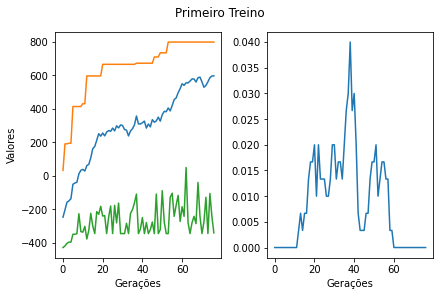

<Figure size 960x480 with 0 Axes>

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = True)
fig.suptitle('Primeiro Treino')
fig = plt.figure(figsize=(12, 6), dpi=80)


ax2.plot(generation_win_rate)
ax2.set(xlabel='Gerações')


ax1.plot(gen_avg, label = "media")
ax1.plot(gen_max_values, label = "max")
ax1.plot(gen_min_values, label = "min")

ax1.set(xlabel='Gerações', ylabel='Valores')
plt.show()
# No gráfico da esquerda podemos ver o score minimo de uma geração x em verde, a média da população em azul e o score máximo da população em laranja
# No grafico da direita temos o winrate

In [57]:
# Propriedades da primeira geração
idx = len(gen_avg) - 1
print('Propriedades da primeira geração!')
print('Número de gerações de treino = ', idx)
print('Melhor individuo: ', gen_max_ind[idx][0])
print('Max winrate: ', max(generation_win_rate))
print('Média final da geração: ', gen_avg[idx])

Propriedades da primeira geração!
Número de gerações de treino =  76
Melhor individuo:  RLRLLRLRRLLLLLRLLRRLLLLLLLLRRLLRLRLLRLLLLRRLLLRLR
Max winrate:  0.04
Média final da geração:  596.3566666666667


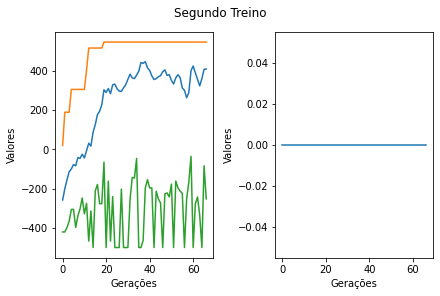

<Figure size 1296x432 with 0 Axes>

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = True)
fig.suptitle('Segundo Treino')

ax2.plot(generation_win_rate_2)
ax2.set(xlabel='Gerações', ylabel='Valores')


ax1.plot(gen_avg_2, label = "media")
ax1.plot(gen_max_values_2, label = "max")
ax1.plot(gen_min_values_2, label = "min")
ax1.set(xlabel='Gerações', ylabel='Valores')
plt.figure(figsize=(18, 6))

plt.show()
# No gráfico da esquerda podemos ver o score minimo de uma geração x em verde, a média da população em azul e o score máximo da população em laranja
# No grafico da direita temos o winrate

In [56]:
# Propriedades da segunda geração
idx_2 = len(gen_avg_2) - 1
print('Propriedades da segunda geração!')
print('Número de gerações de treino = ', idx_2)
print('Melhor individuo: ', gen_max_ind_2[idx_2][0])
print('Max winrate: ', max(generation_win_rate_2))
print('Média final da geração: ', gen_avg_2[idx_2])

Propriedades da segunda geração!
Número de gerações de treino =  66
Melhor individuo:  RLRLLRRRLRRLLRRLRRRLLLRRRLR
Max winrate:  0.0
Média final da geração:  408.79166666666663


### Rodando o melhor agente no terminal obtivemos o seguinte resultado:
![Terminall](./evolutionBestAgent.JPG)

# Conclusões do genetic algorithm desenvolvido
* Melhores individuos de cada uma respectivamente: RLRLLRLRRLLLLLRLLRRLLLLLLLLRRLLRLRLLRLLLLRRLLLRLR(49) e RLRLLRRRLRRLLRRLRRRLLLRRRLR(27). É interessante perceber que as configurações convergiram para tamanhos bem diferentes, entretanto o início do caminho das duas (primeiros 6 caracteres) são idênticos. A primeira população teve mais gerações que a segunda, evoluindo por mais 10 gerações até chegar no critério de parada.
* High score do primeiro individuo de 798 pontos e do segundo de 546 pontos, sendo assim a primeira população teve um fitness maior que a segunda. Isso é demonstrado pela média da população, que a primeira chegou a quase 600 pontos e na segunda por volta de 400.
* As médias das populações ao final também foram bem próximas. Mas a primeira teve um ponto em que o valor mínimo teve um pico acima de 0.
* O winrate da primeira geração teve um maior número de modificações ao longo das populações. Chegando a 4% de vitorias em um ponto do treinamento. Entretando, não conseguimos levar essa configuração a longo prazo, já que a fitness não levava as vitorias em seu calculo. Assim, essa propriedade de vitorias foi se perdendo ao longo do treino. No caso da segunda população, essa caracteristica do jogo não saiu do zero.
* Apesar da parametrização e diversos testes, não conseguimos uma boa solução para o problema proposto utilizando este modelo desenvolvido, já que o pacman não chega a ganhar todos os mapas e percorrer todos os caminhos. Apesar disso, mesmo sendo uma solução simples, ele consegue maximizar a média da população chegando a um valor positivo da média da população.

## Problemas com o modelo desenvolvido e impedimentos:
* Como os labirintos tem formas muito diferentes, era muito difícil criar um indivíduo generalista para os 3 mapas testados. Alguns desses mapas possuíam corredores ou curvas inúteis, que o agente sempre tomava por não levar em conta a melhor pontuação para tomar sua próxima ação. Além disso, um agente que iria muito bem em um mapa, poderia ficar em um loop em outro mapa tomando os mesmos conjuntos de ações, desse modo ele apenas esperava sua morte por um fantasma em um dos mapas, mesmo indo extremamente bem em outro.
* Não levar em conta a posição dos fantasmas foi um problema, já que o pacman não tomava uma rota de fuga caso o fantasma se aproximasse dele. Dessa forma, existiam indivíduos que apenas seguiam de encontro a um fantasma ou realmente realizavam um caminho de seguir o fantasma a 1 bloco de distância, mesmo não tendo consumido a "power pill", o que pode configurar jogadas bem arriscadas e com baixa probabilidade de sobrevivência.
* Não conseguirmos levar em conta as vitorias dos jogos na fitness do indivíduo, pois levava a máximos locais e dava um break na evolução da população.
* Ao longo de nossos testes inciais, permitiamos um grande número de repetições de indivíduos em uma população. Nesses testes até conseguimos um bom resultado, mas não significou uma boa população:
> Generation 43 <br>
> Avg = 350.86 <br>
> Win rate = 0.2633333333333333 <br>
> Max Value = 585.0 <br>
> Min value = -354.3333333333333 <br>
 max_score = 585.0 ind = (array([95], dtype=int64),): ['RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRR'] <br><br>
Apesar de ter um win rate de mais de 1 em cada 4 jogos, essa população obteve esse resultado por conta de 1 indivíduo que dominou praticamente 60% da população e ganhava em apenas 1 mapa. Isso se demonstrou um problema de overfitting, já que a população inteira era especialista em vencer 1 dos mapas. Este problema foi solucionado com uma melhor seleção dos indivíduos para elitismo, garantindo que eles não fossem repetidos.
* Todos os nossos testes acabaram levando para um máximo local, onde um individuo ganhava ou conseguia muitos pontos em um dos mapas, mas não conseguia ter sucesso nos outros mapas testados.

## Soluções pensadas
* A repetição de individuos tem que ser limitada, para que o algoritmo consiga continuar explorando novas possibilidades para os demais mapas.
* O agente criado deveria ser modificado para levar em conta outras ações do jogo além de apenas virar, para que o pacman possa realmente tomar a melhor decisão na hora de se locomover pelo labirinto, evitando encontros com o fantasma e curvas desnecessárias.
* Acredito que um individuo generalista para os 3 mapas seja muito difícil de ser encontrado pela diferença e complexidade dos mapas, se separassemos o problema em achar o melhor pacman para cada um dos mapas teriamos um melhor resultado.
* Outro fator pensado foi adicionar um novo alelo 'F', sendo assim teriamos mais uma possibilidade de movimentação do Pacman (seguir em frente) dentre as apresentadas nesse relatório.

## Ponto interessante observado
* Ao longo dos treinos inciais, pudemos observar o poder de uma mutação. O contexto do output abaixo: um individuo estava dominando a população e acabou sendo escolhido para realizar uma mutação. A mutação de 1 gene seu alterou o caminho realizado pelo pacman de forma que a pontuação média atingida foi maior que o individuo gerador, acabando com a dominância de maior média do individuo original. Podemos ver o trecho abaixo dos logs de duas gerações onde a 43 é filha da 42:
> Generation 42 <br>
Avg = 364.3500000000001 <br>
Win rate = 0.28 <br>
Max Value = 539.0 <br>
Min value = -354.3333333333333 <br>
max_score = 539.0 ind = (array([ 0,  1,  2,  3,  4,  5,  6,  7, 18, 26, 30, 36, 48, 51, 53, 56, 70],
      dtype=int64),): ['RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'
 'RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRL'] <br>

> Generation 43 <br>
Avg = 350.86  <br>
Win rate = 0.2633333333333333 <br>
Max Value = 585.0 <br>
Min value = -354.3333333333333 <br>
max_score = 585.0 ind = (array([95], dtype=int64),): ['RRLRLLRLLRRLLLLRLRLLRLRLLRRRRRRLLRR'] <br>
podemos saber que o individuo cirado foi originado de mutação pela sua posição no vetor: os 10 primeiros eram de stedy state, seguido por 80 individuos gerados por crossoveer e os últimos 10 eram gerados por mutação.

# Reinforcement Learning:
## Introdução

* Tendo em mente o estado atual do tabuleiro, que contem as posições dos fantasmas, a posição do pacman, todas as posições das comidas disponíveis e que a cada atualização do pacman podemos calcular a reward pelo score do tabuleiro, nesta etapa do projeto gostaríamos de desenvolver um modelo baseado em um algoritmo Q-learning.
* Como o número de estados do pacman é muito grande (levando em conta as propriedades do jogo listadas acima) e calcular a Q-table seria oneroso, tomaremos o caminho de um aproximate Q-Learning, onde teremos as features e seus pesos calculados conforme os estados são visitados, tomando uma abordagem SARSA<br>
* Dessa forma, podemos mapear as seguintes features: <br>
    -> Algum bias para ele sempre tomar uma ação de se mover<br>
    -> Se na ação tomada a partir do estado ele come uma comida, o que é bom, já que aumenta o score (recompensa positiva)<br>
    -> A comida mais próxima do estado, quanto mais próximo de uma comida ele estiver, menos pontos ele perde se movendo sem comer nada, quanto mais próximo de 0 melhor (reward positivo)<br>
    -> Número de fantasmas que ficam a 1 de distância do pacman caso a ação seja tomada, já que isso significa uma ameaça ao jogo, pois se o pacman encostar em um fantasma o jogo acaba (recompensa negativa)<br>
    -> Fantasma assustado mais próximo, se existem fantasmas assustados. Isso recompensa o fantasma positivamente, já que comer um fantasma assustado aumenta bastante o score do jogo.
* Em um dado momento do jogo, posso calcular o QValue de um estado do jogo por meio de:   <br>
    -> QValue = sum( weights(f) * f) para toda feature f.   <br>
    -> Queremos que os pesos de cada feature se ajustem de forma que o Pacman tome sempre a ação que o leva para o estado com o maior QValue a partir do estado atual. Tomar a ação que leva ao estado com maior QValue será nossa regra para os testes.
* Além disso, as ações em um determinado estado são os movimentos que o pacman pode realizar no jogo.
* Inicialmente, cada um dos pesos para as features é iniciado como 0 e esses valores serão ajustados durante o treino.
* Para o treino, exite uma probabilidade de tomar uma ação aleatória ou a melhor ação determinada por uma variável de exploração (epsilon). Essa exploração garante que o pacman visite diferentes cenários e ajuste os pesos das features de acordo com os cenários alcançados após a ação.
* Após tomar uma ação, os pesos são atualizados de acordo com a recompensa seguindo a função a seguir:   <br>
    -> difference = reward + (gamma \* QValue(nextState) - QValue(state, action))   <br>
    -> para toda feature f   <br>
    ->      weights(f) = weights(f) + alpha \* i \* difference   <br>
* Para a recompensa:  <br>
    -> Sendo last a pontuação atingida no último estado e current a pontuação atingida no estado atual, podemos calcular uma recompensa como sendo '**reward = current - last**'. Essas pontuações podem ser computadas pelo próprio jogo, que calcula de acordo com o tempo, comidas pelas quais o pacman passou, etc.
* Como visto nas equações acima, para a aplicação do modelo temos 3 diferentes parâmetros: alpha, gamma e epsilon, sendo eles: learning rate, discount factor e exploration probabability respectivamente.

A discussão foi baseada na aula e nos seguintes links: [State–action–reward–state–action](https://en.wikipedia.org/wiki/State%E2%80%93action%E2%80%93reward%E2%80%93state%E2%80%93action) [Swarthmore](https://www.cs.swarthmore.edu/~bryce/cs63/s16/slides/3-25_approximate_Q-learning.pdf) [Q-learning](https://en.wikipedia.org/wiki/Q-learning) [UC Berkeley](http://ai.berkeley.edu/reinforcement.html#Q4)


## Implementação

* Por problemas com a interface com o jogo e suas classes não tivemos tempo para entender e implementar o algoritmo AproximateQLearning do zero na biblioteca de pacman apresentada, treinar o modelo e trazer resultados para apresentarmos neste relatório. 
* Entretando, durante pequisas conseguimos encontrar um agente utilizando QLearn implementado no seguinte repositório [github](https://github.com/srinadhu/RL_Pacman/tree/8f02fd3ad39fc534655ec06259109e0ab049f077).
* Tentamos adaptar o codigo apresentado pelo repo para o nosso modelo a partir de algumas mudanças: <br>
-> Valores para os diferentes parâmetros do modelo, principalmente exploração para que o pacman treine melhor comer os fantasmas <br>
-> Adicionar a feature na qual o Pacman come um fantasma assustado <br>
-> Adicionar a feature na qual o Pacman busca pelas pílulas de poder <br>
Apesar das mudanças feitas, não conseguimos grandes diferenças nos resultados obtidos pelo algorítmo original e portanto não apresentaremos os resultados obtidos. Um exemplo de como rodar o algoritmo é mostrada abaixo

In [65]:
!python pacman.py -p ApproximateQAgent -a epsilon=0.85,gamma=0.7,alpha=0.15  -x 100 -n 110 -l mediumClassic
# x é o número de episódios que o pacman irá treinar, gamma, epsilon e alpha são os parâmetros do modelo a ser treinado
# a partir do episódio x até n é a fase de teste que o algoritmo tenta tomar sempre a melhor decisão, tendo gamma e alpha zerados, dessa forma os pesos são mantidos

Beginning 100 episodes of Training
Num_actions =  39
Episode Rewards =  102.0
Num_actions =  19
Episode Rewards =  92.0
Num_actions =  30
Episode Rewards =  41.0
Num_actions =  62
Episode Rewards =  109.0
Num_actions =  47
Episode Rewards =  124.0
Num_actions =  88
Episode Rewards =  203.0
Num_actions =  18
Episode Rewards =  53.0
Num_actions =  13
Episode Rewards =  38.0
Num_actions =  137
Episode Rewards =  174.0
Num_actions =  58
Episode Rewards =  63.0
Num_actions =  46
Episode Rewards =  145.0
Num_actions =  22
Episode Rewards =  29.0
Num_actions =  63
Episode Rewards =  38.0
Num_actions =  54
Episode Rewards =  167.0
Num_actions =  69
Episode Rewards =  272.0
Num_actions =  56
Episode Rewards =  85.0
Num_actions =  32
Episode Rewards =  89.0
Num_actions =  171
Episode Rewards =  350.0
Num_actions =  28
Episode Rewards =  63.0
Num_actions =  45
Episode Rewards =  126.0
Num_actions =  61
Episode Rewards =  110.0
Num_actions =  90
Episode Rewards =  191.0
Num_actions =  41
Episode R

# Comparativo
Em suma, nosso algoritmo evolutivo possui uma estrutura muito simples, que não leva em conta a estocasticidade do problema do pacman. Dessa forma, não conseguimos garantir que ele terá uma boa performance em jogos com posições aleatórias dos fantasmas. Entretanto, ele se fez útil para o problema proposto para ele: consegue percorrer um caminho específico para maximizar a pontuação média da população, mesmo que ele não consiga performar bem em mapas maiores que aumentam as possibildades de caminhos. <br>
Ainda sobre a programação genética, da maneira que implementamos o algoritmo e suas estruturas de dados, ele se faz um algoritmo com uma performance baixa, pois precisa de um alto número de individuos diferentes para testar as diferentes possibildiades de caminho no labirinto. Além de ter um grande custo na computação das médias e fitness dos individuos.

Agora sobre o algoritmo de reinforcement learning: esperávamos ter um ganho de performance e resultados melhores com sua implementação. Isso por uma série de fatores: 
* Com a adição de features que levam em conta o posicionamento dos fantasmas, estaríamos em linha com a estocasticidade do problema, dessa forma o fantasma iria aprender a jogar em diferentes cenários e situações do jogo, bem como aprender a jogar em diferentes mapas.
* A recompensa é facilmente obtida pelo score do jogo
* Não precisariamos guardar tantas estruturas para o aprendizado do modelo> apenas as features e seus pesos já são capazes de calcular os valores necessários para a escolha. 
* Uma quantidade menor de jogos seria necessária para treinar o algoritmo, dessa forma, um menor tempo de treino seria necessário. <br><br>
> Infelizmente não conseguimos realizar a nossa implementação do aprendizado por reforço, mas com um breve periodo de testes e análises em um algoritmo similar obtido pelo github percebemos que as nossas expectativas poderiam ser atingidas e melhoras de um modelo para o outro poderiam ser observadas.